In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import copy

In [2]:
label_def_similar_shapes = {'background': 0, 'f_s20_40_20_40_B_G': 1, 'm20_100': 2, 'm20_30': 3, 'r20': 4, 
             'bearing_box': 5, 'bearing': 6, 'axis': 7, 'distance_tube': 8, 'motor': 9, 
             'container': 10, 'em_01': 11, 'em_02': 12}

label_def_full = {'background': 0, 'f20_20_B': 1, 's40_40_B': 2, 'f20_20_G': 3, 's40_40_G': 4,  
             'm20_100': 5, 'm20': 6, 'm30': 7, 'r20': 8, 'bearing_box_ax01': 9, 'bearing': 10, 'axis': 11, 
             'distance_tube': 12, 'motor': 13, 'container_box_blue': 14, 'container_box_red': 15, 
             'bearing_box_ax16': 16, 'em_01': 17, 'em_02': 18}

label_def_size_invariant = {'background': 0, 'f_s20_40_20_40_B': 1, 'f_s20_40_20_40_G': 2,
                            'm20_100': 3, 'm20_30': 4, 'r20': 5, 'bearing_box': 6, 
                            'bearing': 7, 'axis': 8, 'distance_tube': 9, 'motor': 10, 'container_box_blue': 11, 
                            'container_box_red': 12, 'em_01': 13, 'em_02': 14}

label_def_binary = {'background': 0, 'foreground': 1}

variant_to_label_def = {'full': [label_def_full, 'atWork_full', 'f'], 
                        'binary': [label_def_binary, 'atWork_binary', 'b'],
                        'shape': [label_def_similar_shapes, 'atWork_similar_shapes', 'sh'], 
                        'size': [label_def_size_invariant, 'atWork_size_invariant', 'si'], 
                        'white_full': [label_def_full, 'atWork_full_white', 'wf'], 
                        'white_binary': [label_def_binary, 'atWork_binary_white', 'wb'],
                        'white_shape': [label_def_similar_shapes, 'atWork_similar_shapes_white', 'wsh'], 
                        'white_size': [label_def_size_invariant, 'atWork_size_invariant_white', 'wsi'],
                        'real_full': [label_def_full, 'atWork_full_real', 'rf'], 
                        'real_binary': [label_def_binary, 'atWork_binary_real', 'rb'],
                        'real_shape': [label_def_similar_shapes, 'atWork_similar_shapes_real', 'rsh'], 
                        'real_size': [label_def_size_invariant, 'atWork_size_invariant_real', 'rsi']}

In [3]:
class DataAnalysis():
    
    def __init__(self, VARIANT='full', 
                 LABEL_PATH='./objects/real_augmented/training/size_invariant'):
        
        self.variant = variant_to_label_def[VARIANT][1]
        self.in_filename = variant_to_label_def[VARIANT][2]
        self.label_path = LABEL_PATH
        self.label_def = variant_to_label_def[VARIANT][0]
        
        file_paths = self.read_labels()
        self.image_to_cls_to_pixelCount = self.initialize_data_dict()
        self.total_pixels = self.get_total_pixels(file_paths)
        self.populate_data_dict(file_paths)
    
    def read_labels(self):
            
        return [os.path.join(self.label_path, file) for file in
               os.listdir(self.label_path)]
    
    def initialize_data_dict(self):
        
        image_to_cls_to_pixelCount = {}
        cls_to_pixelCount = {key:0 for key in range(len(self.label_def))}
        for file in os.listdir(self.label_path):
            image_to_cls_to_pixelCount[file] = cls_to_pixelCount.copy()
            
        return image_to_cls_to_pixelCount
    
    def get_total_pixels(self, file_paths):
        
        img_dimension = cv2.imread(file_paths[0], 0).shape
        return img_dimension[0]*img_dimension[1]*len(file_paths)
    
    def populate_data_dict(self, file_paths):
        
        for file in file_paths:
            img = cv2.imread(file, 0)
            clses = np.unique(img)
            img_name = file.split('/')[-1]

            for cls in clses:      
                self.image_to_cls_to_pixelCount[img_name][cls] = np.shape(
                                                        np.argwhere(img==cls))[0]

            if sum(self.image_to_cls_to_pixelCount[img_name].values()
                                      ) != img.shape[0]*img.shape[1]:
                raise ValueError('Not all pixels have been counted...')
                
    def get_cls_to_percentage(self):
        
        cls_to_percentage = {key:0 for key in self.label_def.keys()}
        for count_dict in self.image_to_cls_to_pixelCount.values():
            for key in cls_to_percentage.keys():
                cls_to_percentage[key] += count_dict.get(self.label_def[key], 0)

        return {key:round((value/self.total_pixels)*100, 4) for key, value in 
                                            cls_to_percentage.items()}
    
    def plot_cls_to_x(self, cls_to_x, y_label, ignore_background=False,
                      cls_to_x_validation=None, cls_to_x_test=None, 
                      bar_width=0.3, set_fonts=17, fig_width=15,
                      fig_height=5, display_title=False):
        
        cls_to_x = copy.deepcopy(cls_to_x)
        cls_to_x_validation = copy.deepcopy(cls_to_x_validation)
        cls_to_x_test = copy.deepcopy(cls_to_x_test)
        
        figure = plt.figure(figsize=(fig_width, fig_height))
    
        x = np.array(list(self.label_def.values()))
        x_ticks = np.empty(len(self.label_def), dtype = str)

        for label in self.label_def.keys():
                x_ticks[self.label_def[label]] = label

        if ignore_background:
            cls_to_x.pop('background', None)
            if cls_to_x_validation is not None:
                cls_to_x_validation.pop('background', None)
            if cls_to_x_test is not None:
                cls_to_x_test.pop('background', None)
            x = x[-len(cls_to_x):]
            x_ticks = x_ticks[-len(cls_to_x):]

        cmap = plt.cm.get_cmap('Paired')
        
        plt.bar(x - bar_width, cls_to_x.values(), width=bar_width, 
                 color=cmap(0.2), zorder=3, label='TrainingSet')
        if cls_to_x_validation is not None:
            plt.bar(x, cls_to_x_validation.values(), 
                    width=bar_width, align='center', color=cmap(0.5), 
                    zorder=3, label='ValidationSet')
        if cls_to_x_test is not None:
            plt.bar(x + bar_width, cls_to_x_test.values(), 
                    width=bar_width, color=cmap(0.7), 
                    zorder=3, label='TestSet')

        plt.xlabel('class name', fontsize=set_fonts)
        plt.ylabel(y_label, fontsize=set_fonts)
        if display_title:
            plt.title('Dataset variant: {}'.format(self.variant),
                     fontsize=set_fonts)
        plt.xticks(x, cls_to_x.keys(), rotation=80)
        plt.grid(zorder=0, axis='y')
        plt.tick_params(axis='both', which='major', labelsize=set_fonts)
        plt.legend(fontsize=set_fonts)
        
        if ignore_background:
            plt.savefig('../report_on_dataset/images/'+'_'.join(y_label.split(' '))+
                        '_'+self.in_filename+'_noB.png', bbox_inches="tight")
        else:
            plt.savefig('../report_on_dataset/images/'+'_'.join(y_label.split(' '))+
                        '_'+self.in_filename+'.png', bbox_inches="tight")
            
        plt.show()
        
    def get_cls_to_weight(self, cls_to_percentage, set_background_weight=None):
        
        cls_to_weight = {key: round(1/(100*value),4)
                         for key, value in cls_to_percentage.items()}

        normalizer = sum(cls_to_weight.values()) - cls_to_weight['background']
        
        if set_background_weight is None:
            background_weight = cls_to_weight['background']  
        else:
            background_weight = set_background_weight

        cls_to_weight = {key: round(value*(1 - background_weight)/normalizer, 4) 
                         if key is not 'background'
                        else background_weight for key, value in cls_to_weight.items()}

        if abs(1. - sum(cls_to_weight.values())) > 1e-3:
            raise ValueError (
                'The sum of weights is {}... The weights have not been normalized...'.
                format(sum(cls_to_weight.values())))

        return cls_to_weight
    
    def get_weight_list(self, cls_to_weight):
        
        weight_list = np.zeros(len(self.label_def))
        for label in self.label_def.keys():
            weight_list[self.label_def[label]] = cls_to_weight[label]

        return list(weight_list)
    
    def get_cls_to_count(self, cls_to_percentage):
        
        cls_to_count = {key:0 for key in range(len(self.label_def))}
        for count_dict in self.image_to_cls_to_pixelCount.values():
            cls_to_count = {key: value + 1 if count_dict[key]!=0 
                            else value for key, value in cls_to_count.items()}
            
        cls_to_count = {key: cls_to_count[self.label_def[key]] for 
                        key in cls_to_percentage.keys()}
            
        return cls_to_count

In [4]:
def generate_results(analyzer_train, analyzer_validation,
                    analyzer_test, plot_weights=False, 
                     bar_width=0.3, set_fonts=17, fig_width=15,
                     fig_height=5, display_title=False, set_background_weight=None):
    
    # Generate percentage of pixels plot..
    cls_to_percentage_tr = analyzer_train.get_cls_to_percentage()
    cls_to_percentage_va = analyzer_validation.get_cls_to_percentage()
    cls_to_percentage_te = analyzer_test.get_cls_to_percentage()

    print("Percentage of pixels of each class in the training set:\n")
    print(cls_to_percentage_tr)
    print('-----------------------------------------------------------\n')
    print("Percentage of pixels of each class in the validation set:\n")
    print(cls_to_percentage_va)
    print('-----------------------------------------------------------\n')
    print("Percentage of pixels of each class in the test set:\n")
    print(cls_to_percentage_te)
    print('-----------------------------------------------------------\n')
    
    print('Class to percentage with background....\n')
    analyzer_train.plot_cls_to_x(cls_to_percentage_tr, 'percentage of pixels', 
                                   ignore_background=False, 
                                   cls_to_x_validation=cls_to_percentage_va, 
                                   cls_to_x_test=cls_to_percentage_te,
                                   bar_width=bar_width, set_fonts=set_fonts,
                                   fig_width=fig_width, fig_height=fig_height,
                                   display_title=display_title)
    
    print('Class to percentage without background....\n')
    analyzer_train.plot_cls_to_x(cls_to_percentage_tr, 'percentage of pixels', 
                                   ignore_background=True, 
                                   cls_to_x_validation=cls_to_percentage_va, 
                                   cls_to_x_test=cls_to_percentage_te,
                                   bar_width=bar_width, set_fonts=set_fonts,
                                   fig_width=fig_width, fig_height=fig_height,
                                   display_title=display_title)
    
    # Generate weights plot....
    if plot_weights:
        cls_to_weight_tr = analyzer_train.get_cls_to_weight(
                                    cls_to_percentage_tr,
                                    set_background_weight=set_background_weight)
        cls_to_weight_va = analyzer_validation.get_cls_to_weight(
                                    cls_to_percentage_va,
                                    set_background_weight=set_background_weight)
        cls_to_weight_te = analyzer_test.get_cls_to_weight(
                                    cls_to_percentage_te,
                                    set_background_weight=set_background_weight)
        
        print('Class to weight with background....\n')
        analyzer_train.plot_cls_to_x(cls_to_weight_tr, 'class weight', 
                                       ignore_background=False, 
                                       cls_to_x_validation=cls_to_weight_va, 
                                       cls_to_x_test=cls_to_weight_te,
                                       bar_width=bar_width, set_fonts=set_fonts,
                                       fig_width=fig_width, fig_height=fig_height,
                                       display_title=display_title)
        
        print('Class to weight without background....\n')
        analyzer_train.plot_cls_to_x(cls_to_weight_tr, 'class weight', 
                                       ignore_background=True, 
                                       cls_to_x_validation=cls_to_weight_va, 
                                       cls_to_x_test=cls_to_weight_te,
                                       bar_width=bar_width, set_fonts=set_fonts,
                                       fig_width=fig_width, fig_height=fig_height,
                                       display_title=display_title)
        
    # Generate count of objects plot...
    cls_to_count_tr = analyzer_train.get_cls_to_count(cls_to_percentage_tr)
    cls_to_count_va = analyzer_validation.get_cls_to_count(cls_to_percentage_va)
    cls_to_count_te = analyzer_test.get_cls_to_count(cls_to_percentage_te)
    
    print('Class to count with background....\n')
    analyzer_train.plot_cls_to_x(cls_to_count_tr, 'class count', 
                                   ignore_background=False, 
                                   cls_to_x_validation=cls_to_count_va, 
                                   cls_to_x_test=cls_to_count_te,
                                   bar_width=bar_width, set_fonts=set_fonts,
                                   fig_width=fig_width, fig_height=fig_height,
                                   display_title=display_title)
    
    print('Class to count without background....\n')
    analyzer_train.plot_cls_to_x(cls_to_count_tr, 'class count', 
                                   ignore_background=True, 
                                   cls_to_x_validation=cls_to_count_va, 
                                   cls_to_x_test=cls_to_count_te,
                                   bar_width=bar_width, set_fonts=set_fonts,
                                   fig_width=fig_width, fig_height=fig_height,
                                   display_title=display_title)

def plot(cls_to_x, y_label, ignore_background=False,
                      cls_to_x_validation=None, cls_to_x_test=None, 
                      bar_width=0.3, set_fonts=17, fig_width=15,
                      fig_height=5, display_title=False):
    
    label_def = variant_to_label_def['binary'][0]
    cls_to_x = copy.deepcopy(cls_to_x)
    cls_to_x_validation = copy.deepcopy(cls_to_x_validation)
    cls_to_x_test = copy.deepcopy(cls_to_x_test)

    figure = plt.figure(figsize=(fig_width, fig_height))

    x = np.array(list(label_def.values()))
    x_ticks = np.empty(len(label_def), dtype = str)

    for label in label_def.keys():
            x_ticks[label_def[label]] = label

    if ignore_background:
        cls_to_x.pop('background', None)
        if cls_to_x_validation is not None:
            cls_to_x_validation.pop('background', None)
        if cls_to_x_test is not None:
            cls_to_x_test.pop('background', None)
        x = x[-len(cls_to_x):]
        x_ticks = x_ticks[-len(cls_to_x):]

    cmap = plt.cm.get_cmap('Paired')

    plt.bar(x, cls_to_x.values(), width=bar_width, 
            align='center', color=cmap(0.2), zorder=3, label='TrainingSet')
    if cls_to_x_validation is not None:
        plt.bar(x + bar_width, cls_to_x_validation.values(), 
                width=bar_width, align='center', color=cmap(0.5), 
                zorder=3, label='ValidationSet')
    if cls_to_x_test is not None:
        plt.bar(x - bar_width, cls_to_x_test.values(), 
                width=bar_width, align='center', color=cmap(0.7), 
                zorder=3, label='TestSet')

    plt.xlabel('class name', fontsize=set_fonts)
    plt.ylabel(y_label, fontsize=set_fonts)
    plt.ylim(0, max(cls_to_x.values()) + 10)
    if display_title:
        plt.title('Dataset variant: {}'.format(self.variant),
                 fontsize=set_fonts)
    plt.xticks(x, cls_to_x.keys(), rotation=80)
    plt.grid(zorder=0, axis='y')
    plt.tick_params(axis='both', which='major', labelsize=set_fonts)
    leg = plt.legend(fontsize=set_fonts)

cls_full = {'background': 86.2141, 'f20_20_B': 0.2948, 's40_40_B': 0.4218, 'f20_20_G': 0.2683, 
            's40_40_G': 0.896, 'm20_100': 0.4577, 'm20': 0.2981, 'm30': 0.2921, 'r20': 0.3648, 
            'bearing_box_ax01': 0.8653, 'bearing': 0.2526, 'axis': 0.4214, 'distance_tube': 0.2321, 
            'motor': 0.486, 'container_box_blue': 2.6529, 'container_box_red': 2.2299, 'bearing_box_ax16': 0.5657, 
            'em_01': 1.224, 'em_02': 1.5624}

cls_bin = {'background': 86.2141, 'foreground': 13.7859}

plot(cls_bin, 'percentage', cls_to_x_validation=cls_bin, cls_to_x_test=cls_bin, fig_width=5,
                      fig_height=5, bar_width=0.1, ignore_background=False)

### Analysis of the atWork_full variant:

In [5]:
analyzer_tr_full = DataAnalysis(VARIANT='full', 
                                LABEL_PATH='./objects/real_augmented/training/full')
analyzer_va_full = DataAnalysis(VARIANT='full', 
                                LABEL_PATH='./objects/real_augmented/validation/full')
analyzer_te_full = DataAnalysis(VARIANT='full', 
                                LABEL_PATH='./objects/real_augmented/test/full')

Percentage of pixels of each class in the training set:

{'background': 86.2141, 'f20_20_B': 0.2948, 's40_40_B': 0.4218, 'f20_20_G': 0.2683, 's40_40_G': 0.896, 'm20_100': 0.4577, 'm20': 0.2981, 'm30': 0.2921, 'r20': 0.3648, 'bearing_box_ax01': 0.8653, 'bearing': 0.2526, 'axis': 0.4214, 'distance_tube': 0.2321, 'motor': 0.486, 'container_box_blue': 2.6529, 'container_box_red': 2.2299, 'bearing_box_ax16': 0.5657, 'em_01': 1.224, 'em_02': 1.5624}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 88.8968, 'f20_20_B': 0.5006, 's40_40_B': 0.1221, 'f20_20_G': 0.1991, 's40_40_G': 0.255, 'm20_100': 0.3001, 'm20': 0.4979, 'm30': 0.3951, 'r20': 0.5907, 'bearing_box_ax01': 0.5819, 'bearing': 0.361, 'axis': 0.1508, 'distance_tube': 0.0736, 'motor': 0.9915, 'container_box_blue': 1.4043, 'container_box_red': 1.2011, 'bearing_box_ax16': 0.3029, 'em_01': 1.0581, 'em_02': 2.1175}
----------------------------------------

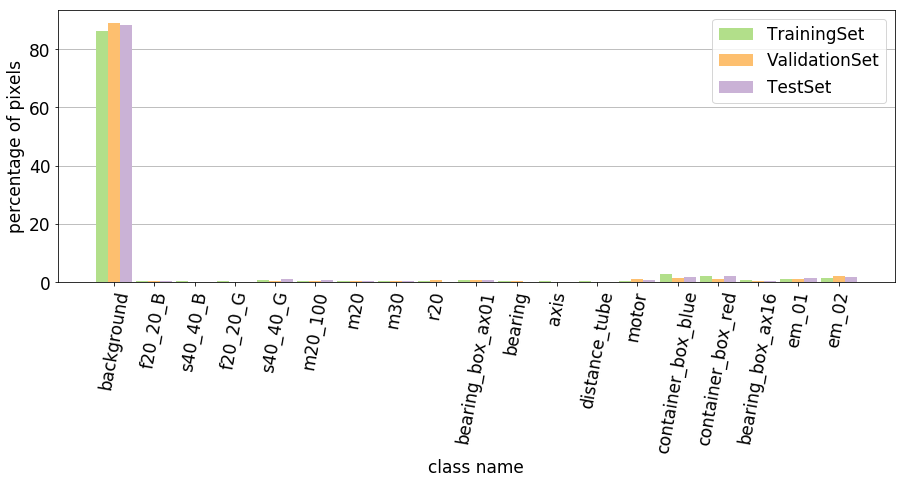

Class to percentage without background....



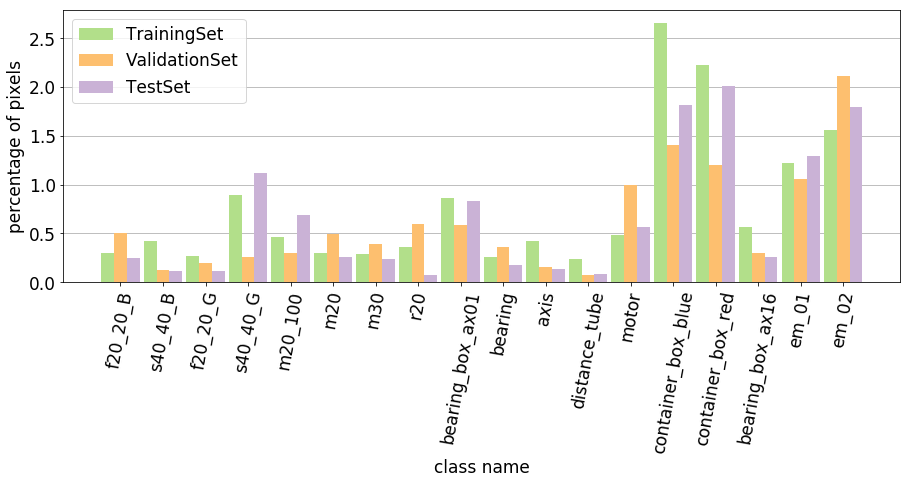

Class to count with background....



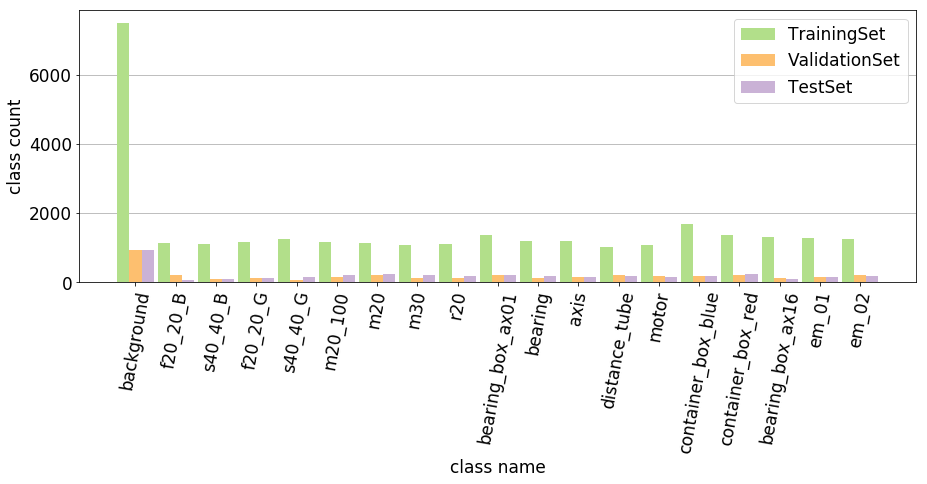

Class to count without background....



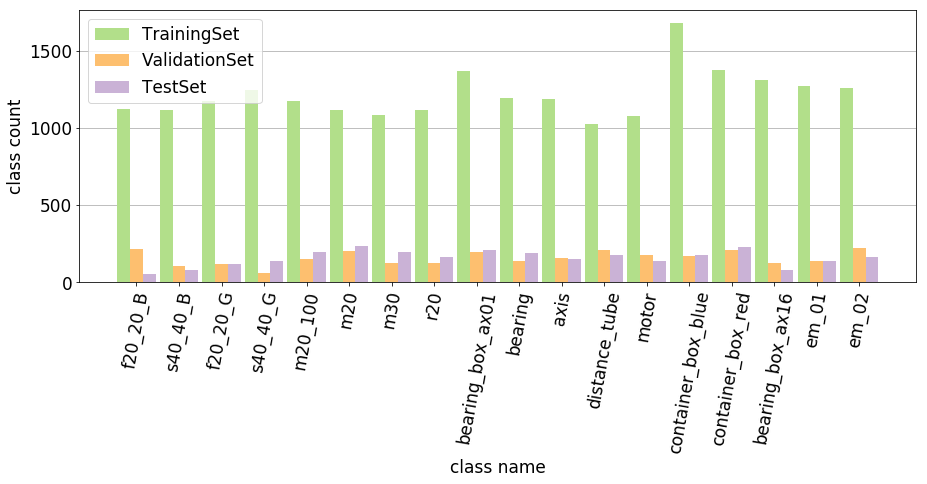

In [6]:
generate_results(analyzer_tr_full, 
                 analyzer_va_full, 
                 analyzer_te_full)

### Analysis of the atWork_size_invariant variant:

In [7]:
analyzer_tr_size = DataAnalysis(VARIANT='size', 
                                LABEL_PATH='./objects/real_augmented/training/size_invariant')
analyzer_va_size = DataAnalysis(VARIANT='size', 
                                LABEL_PATH='./objects/real_augmented/validation/size_invariant')
analyzer_te_size = DataAnalysis(VARIANT='size', 
                                LABEL_PATH='./objects/real_augmented/test/size_invariant')

Percentage of pixels of each class in the training set:

{'background': 86.2141, 'f_s20_40_20_40_B': 0.7166, 'f_s20_40_20_40_G': 1.1643, 'm20_100': 0.4577, 'm20_30': 0.5902, 'r20': 0.3648, 'bearing_box': 1.4311, 'bearing': 0.2526, 'axis': 0.4214, 'distance_tube': 0.2321, 'motor': 0.486, 'container_box_blue': 2.6529, 'container_box_red': 2.2299, 'em_01': 1.224, 'em_02': 1.5624}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 88.8968, 'f_s20_40_20_40_B': 0.6227, 'f_s20_40_20_40_G': 0.4541, 'm20_100': 0.3001, 'm20_30': 0.8931, 'r20': 0.5907, 'bearing_box': 0.8848, 'bearing': 0.361, 'axis': 0.1508, 'distance_tube': 0.0736, 'motor': 0.9915, 'container_box_blue': 1.4043, 'container_box_red': 1.2011, 'em_01': 1.0581, 'em_02': 2.1175}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 88.1941, 'f_s20_40_20_40_B': 0.361, 'f_s20_40_2

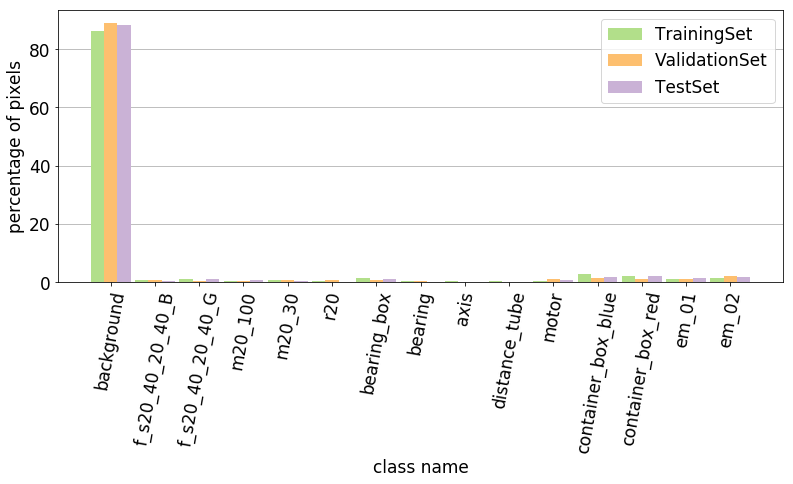

Class to percentage without background....



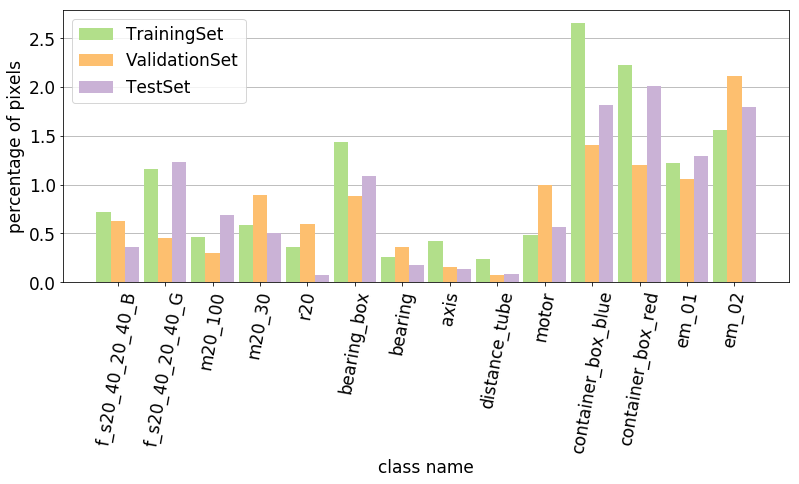

Class to count with background....



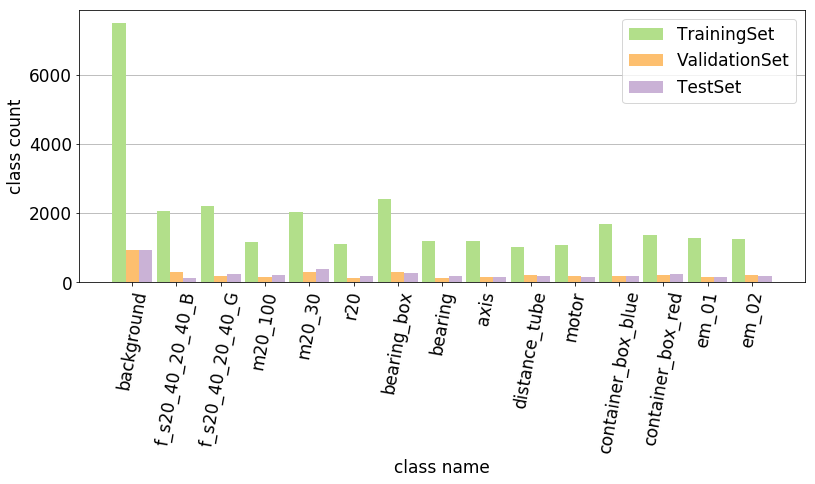

Class to count without background....



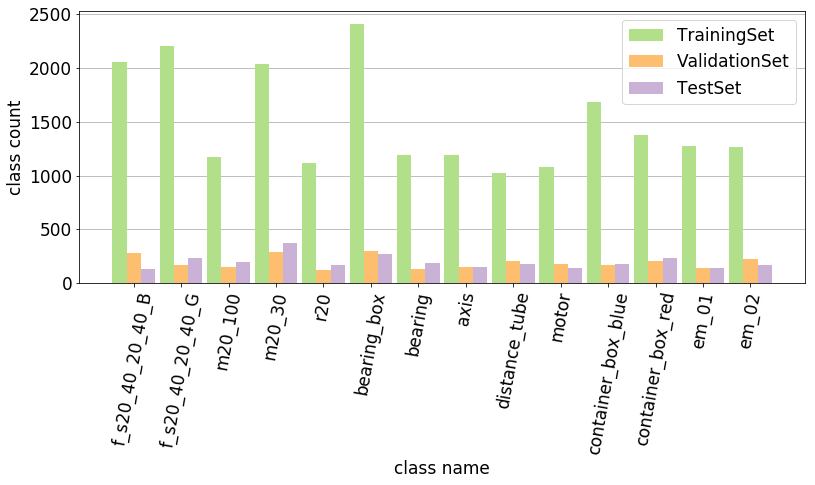

In [8]:
generate_results(analyzer_tr_size, 
                 analyzer_va_size, 
                 analyzer_te_size, fig_width=13)

### Analysis of the atWork_similar_shapes variant:

In [9]:
analyzer_tr_shape = DataAnalysis(VARIANT='shape', 
                                 LABEL_PATH='./objects/real_augmented/training/similar_shapes')
analyzer_va_shape = DataAnalysis(VARIANT='shape', 
                                 LABEL_PATH='./objects/real_augmented/validation/similar_shapes')
analyzer_te_shape = DataAnalysis(VARIANT='shape', 
                                 LABEL_PATH='./objects/real_augmented/test/similar_shapes')

Percentage of pixels of each class in the training set:

{'background': 86.2141, 'f_s20_40_20_40_B_G': 1.8809, 'm20_100': 0.4577, 'm20_30': 0.5902, 'r20': 0.3648, 'bearing_box': 1.4311, 'bearing': 0.2526, 'axis': 0.4214, 'distance_tube': 0.2321, 'motor': 0.486, 'container': 4.8828, 'em_01': 1.224, 'em_02': 1.5624}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 88.8968, 'f_s20_40_20_40_B_G': 1.0767, 'm20_100': 0.3001, 'm20_30': 0.8931, 'r20': 0.5907, 'bearing_box': 0.8848, 'bearing': 0.361, 'axis': 0.1508, 'distance_tube': 0.0736, 'motor': 0.9915, 'container': 2.6054, 'em_01': 1.0581, 'em_02': 2.1175}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 88.1941, 'f_s20_40_20_40_B_G': 1.596, 'm20_100': 0.6892, 'm20_30': 0.5024, 'r20': 0.0752, 'bearing_box': 1.0897, 'bearing': 0.1715, 'axis': 0.1335, 'distance_tube': 0.079, 'mo

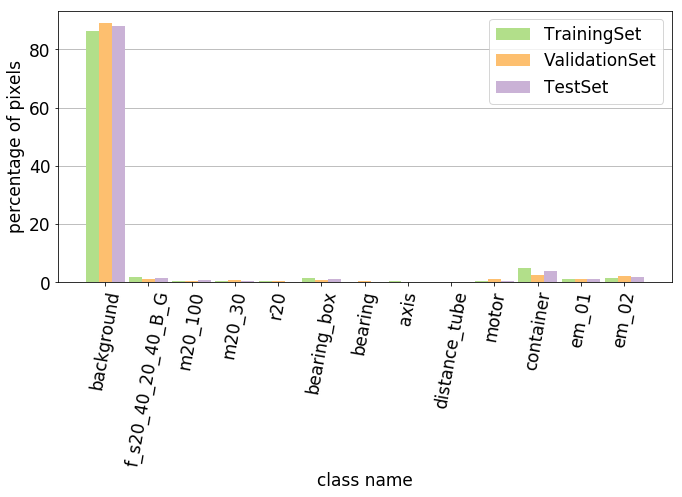

Class to percentage without background....



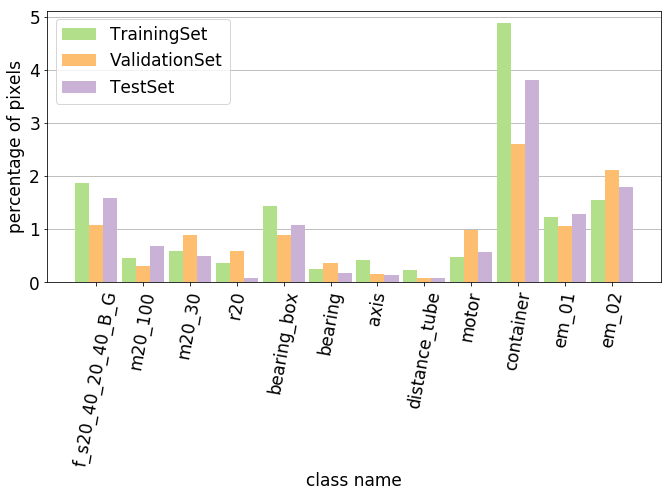

Class to count with background....



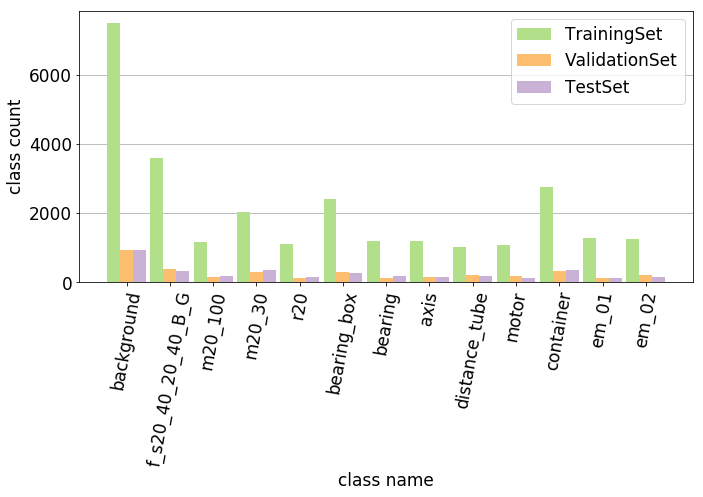

Class to count without background....



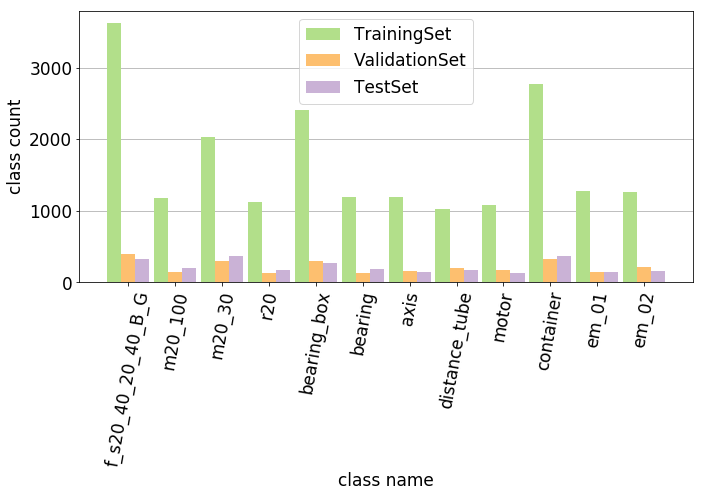

In [10]:
generate_results(analyzer_tr_shape, 
                 analyzer_va_shape, 
                 analyzer_te_shape, fig_width=11)

### Analysis of the atWork_binary variant:

In [11]:
analyzer_tr_binary = DataAnalysis(VARIANT='binary', 
                        LABEL_PATH='./objects/real_augmented/training/binary')
analyzer_va_binary = DataAnalysis(VARIANT='binary', 
                        LABEL_PATH='./objects/real_augmented/validation/binary')
analyzer_te_binary = DataAnalysis(VARIANT='binary', 
                        LABEL_PATH='./objects/real_augmented/test/binary')

Percentage of pixels of each class in the training set:

{'background': 86.2141, 'foreground': 13.7859}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 88.8968, 'foreground': 11.1032}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 88.1941, 'foreground': 11.8059}
-----------------------------------------------------------

Class to percentage with background....



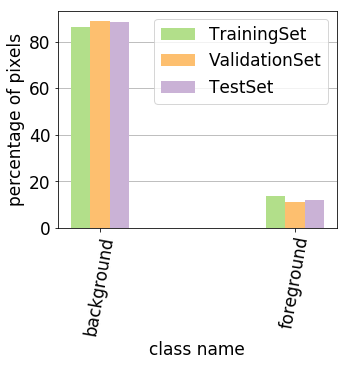

Class to percentage without background....



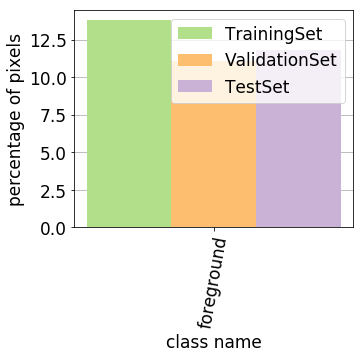

Class to count with background....



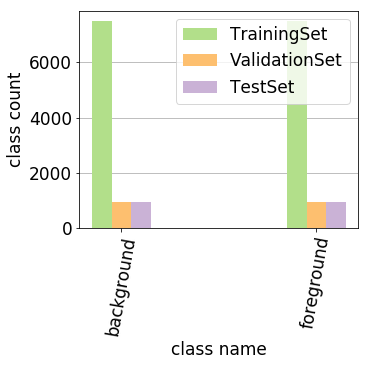

Class to count without background....



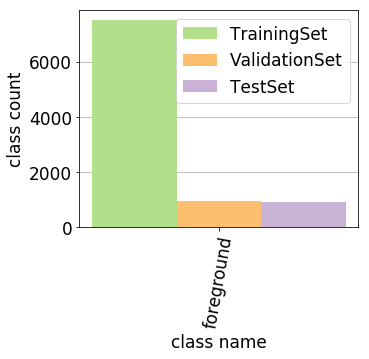

In [12]:
generate_results(analyzer_tr_binary, 
                 analyzer_va_binary, 
                 analyzer_te_binary, fig_width=5, fig_height=4, bar_width=0.1)

### Analysis of the atWork_full variant of the shades of white dataset:

In [13]:
analyzer_tr_full_W = DataAnalysis(VARIANT='white_full', 
                        LABEL_PATH='./objects/white_real_augmented/training/full')
analyzer_va_full_W = DataAnalysis(VARIANT='white_full', 
                        LABEL_PATH='./objects/white_real_augmented/validation/full')
analyzer_te_full_W = DataAnalysis(VARIANT='white_full', 
                        LABEL_PATH='./objects/white_real_augmented/test/full')

Percentage of pixels of each class in the training set:

{'background': 85.9785, 'f20_20_B': 0.3132, 's40_40_B': 0.54, 'f20_20_G': 0.3659, 's40_40_G': 0.7762, 'm20_100': 0.4257, 'm20': 0.2659, 'm30': 0.3702, 'r20': 0.3901, 'bearing_box_ax01': 0.7012, 'bearing': 0.1812, 'axis': 0.4423, 'distance_tube': 0.2688, 'motor': 0.5967, 'container_box_blue': 2.4145, 'container_box_red': 2.4019, 'bearing_box_ax16': 0.5378, 'em_01': 1.1947, 'em_02': 1.8351}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 87.3322, 'f20_20_B': 0.4691, 's40_40_B': 0.1889, 'f20_20_G': 0.6555, 's40_40_G': 0.4409, 'm20_100': 0.5946, 'm20': 0.4554, 'm30': 0.3772, 'r20': 0.4763, 'bearing_box_ax01': 0.7481, 'bearing': 0.1152, 'axis': 0.2695, 'distance_tube': 0.0612, 'motor': 1.0558, 'container_box_blue': 2.0262, 'container_box_red': 1.5902, 'bearing_box_ax16': 0.435, 'em_01': 1.3923, 'em_02': 1.3161}
--------------------------------------

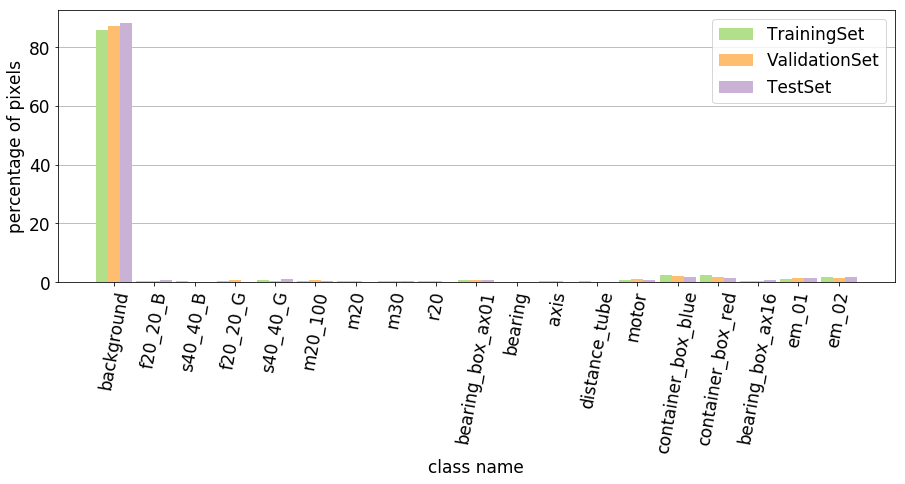

Class to percentage without background....



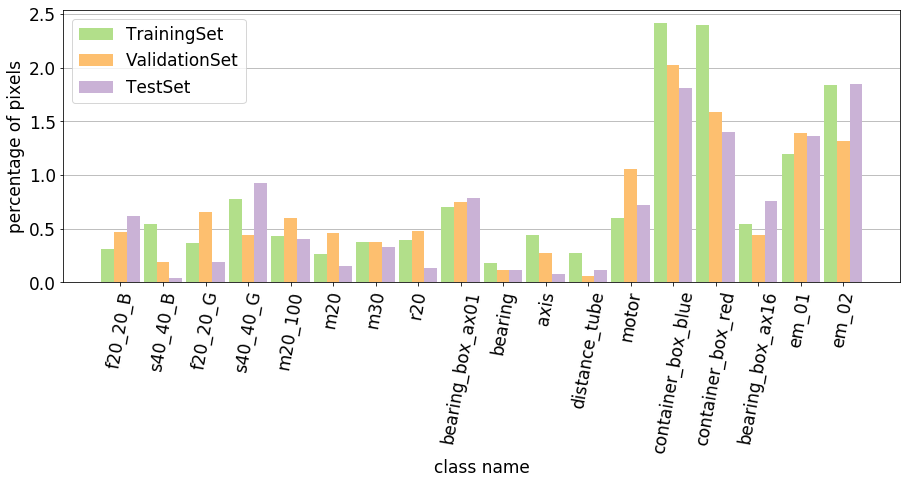

Class to count with background....



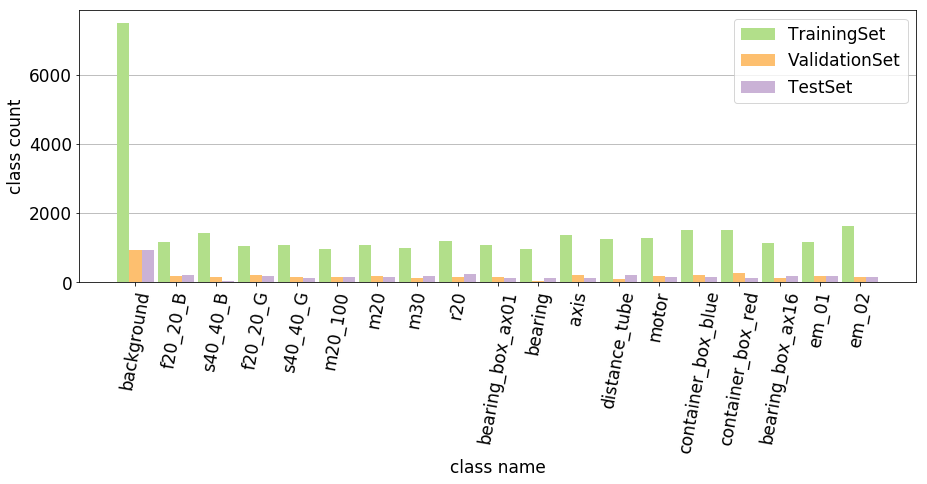

Class to count without background....



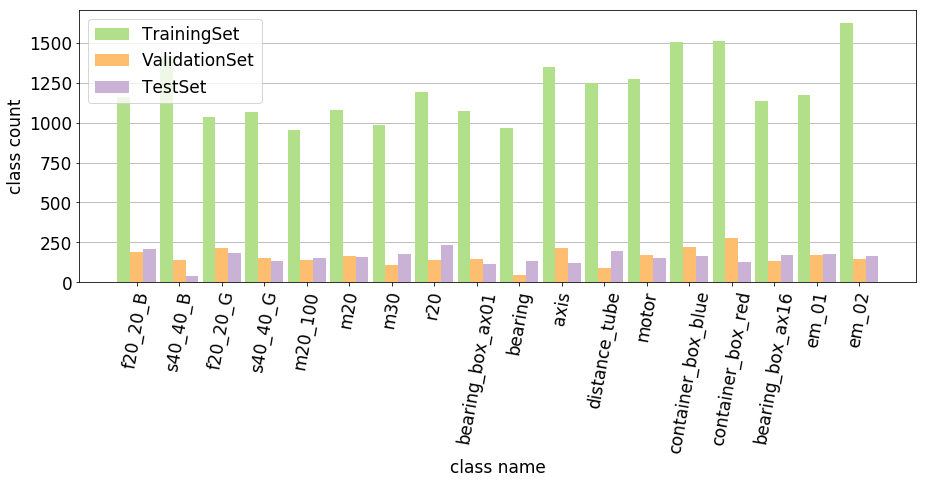

In [14]:
generate_results(analyzer_tr_full_W, 
                 analyzer_va_full_W, 
                 analyzer_te_full_W)

### Analysis of the atWork_size_invariant variant of the shades of white dataset:

In [15]:
analyzer_tr_size_w = DataAnalysis(VARIANT='white_size', 
                                LABEL_PATH='./objects/white_real_augmented/training/size_invariant')
analyzer_va_size_w = DataAnalysis(VARIANT='white_size', 
                                LABEL_PATH='./objects/white_real_augmented/validation/size_invariant')
analyzer_te_size_w = DataAnalysis(VARIANT='white_size', 
                                LABEL_PATH='./objects/white_real_augmented/test/size_invariant')

Percentage of pixels of each class in the training set:

{'background': 85.9785, 'f_s20_40_20_40_B': 0.8532, 'f_s20_40_20_40_G': 1.1421, 'm20_100': 0.4257, 'm20_30': 0.6361, 'r20': 0.3901, 'bearing_box': 1.239, 'bearing': 0.1812, 'axis': 0.4423, 'distance_tube': 0.2688, 'motor': 0.5967, 'container_box_blue': 2.4145, 'container_box_red': 2.4019, 'em_01': 1.1947, 'em_02': 1.8351}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 87.3322, 'f_s20_40_20_40_B': 0.6581, 'f_s20_40_20_40_G': 1.0964, 'm20_100': 0.5946, 'm20_30': 0.8326, 'r20': 0.4763, 'bearing_box': 1.1831, 'bearing': 0.1152, 'axis': 0.2695, 'distance_tube': 0.0612, 'motor': 1.0558, 'container_box_blue': 2.0262, 'container_box_red': 1.5902, 'em_01': 1.3923, 'em_02': 1.3161}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 88.2367, 'f_s20_40_20_40_B': 0.6586, 'f_s20_4

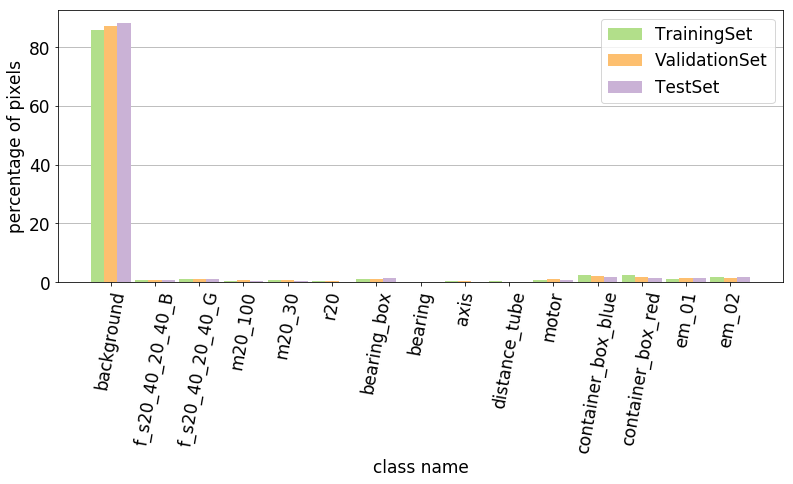

Class to percentage without background....



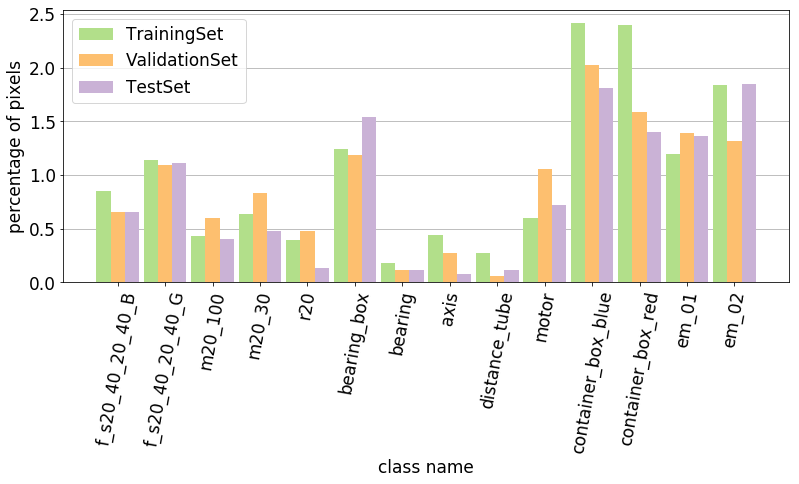

Class to count with background....



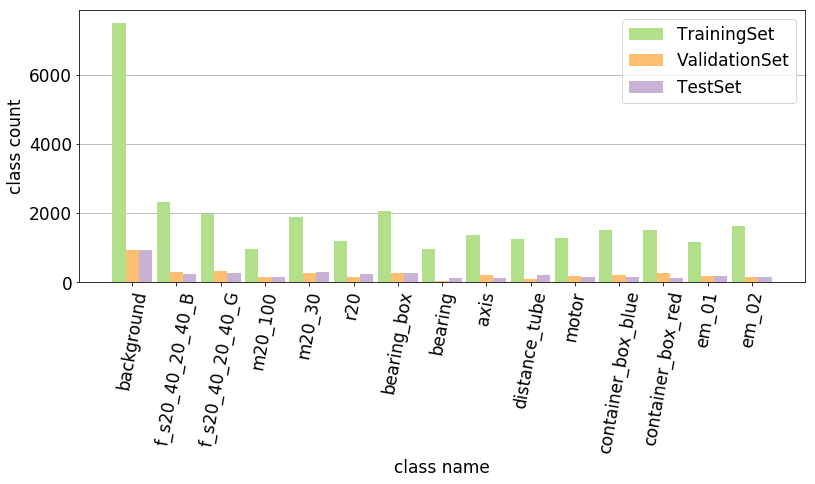

Class to count without background....



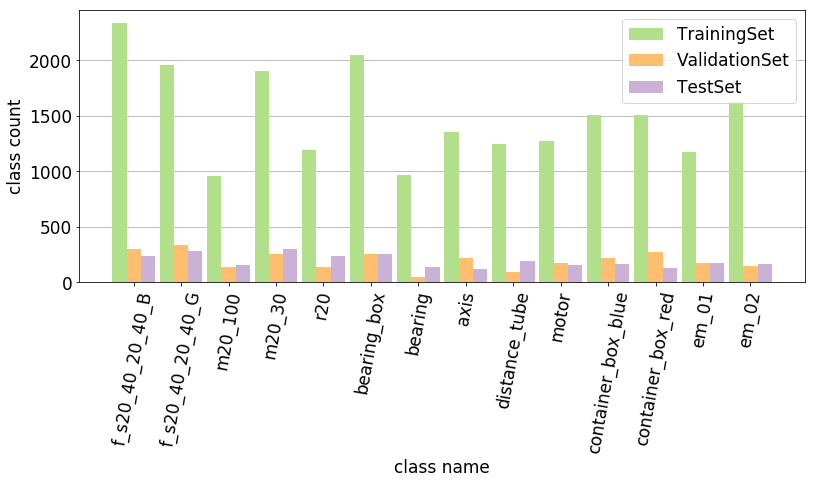

In [16]:
generate_results(analyzer_tr_size_w, 
                 analyzer_va_size_w, 
                 analyzer_te_size_w, fig_width=13)

### Analysis of the atWork_similar_shapes variant of the shades of white dataset:

In [17]:
analyzer_tr_shape_w = DataAnalysis(VARIANT='white_shape', 
                                 LABEL_PATH='./objects/white_real_augmented/training/similar_shapes')
analyzer_va_shape_w = DataAnalysis(VARIANT='white_shape', 
                                 LABEL_PATH='./objects/white_real_augmented/validation/similar_shapes')
analyzer_te_shape_w = DataAnalysis(VARIANT='white_shape', 
                                 LABEL_PATH='./objects/white_real_augmented/test/similar_shapes')

Percentage of pixels of each class in the training set:

{'background': 85.9785, 'f_s20_40_20_40_B_G': 1.9953, 'm20_100': 0.4257, 'm20_30': 0.6361, 'r20': 0.3901, 'bearing_box': 1.239, 'bearing': 0.1812, 'axis': 0.4423, 'distance_tube': 0.2688, 'motor': 0.5967, 'container': 4.8164, 'em_01': 1.1947, 'em_02': 1.8351}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 87.3322, 'f_s20_40_20_40_B_G': 1.7545, 'm20_100': 0.5946, 'm20_30': 0.8326, 'r20': 0.4763, 'bearing_box': 1.1831, 'bearing': 0.1152, 'axis': 0.2695, 'distance_tube': 0.0612, 'motor': 1.0558, 'container': 3.6164, 'em_01': 1.3923, 'em_02': 1.3161}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 88.2367, 'f_s20_40_20_40_B_G': 1.7739, 'm20_100': 0.4015, 'm20_30': 0.4754, 'r20': 0.1334, 'bearing_box': 1.5419, 'bearing': 0.1114, 'axis': 0.0789, 'distance_tube': 0.1177,

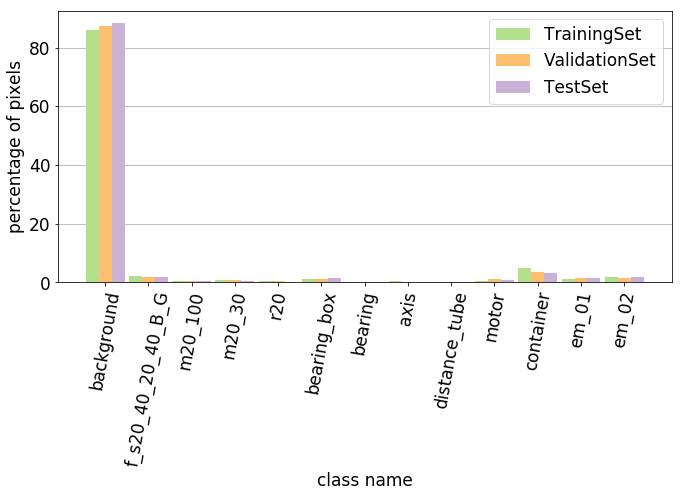

Class to percentage without background....



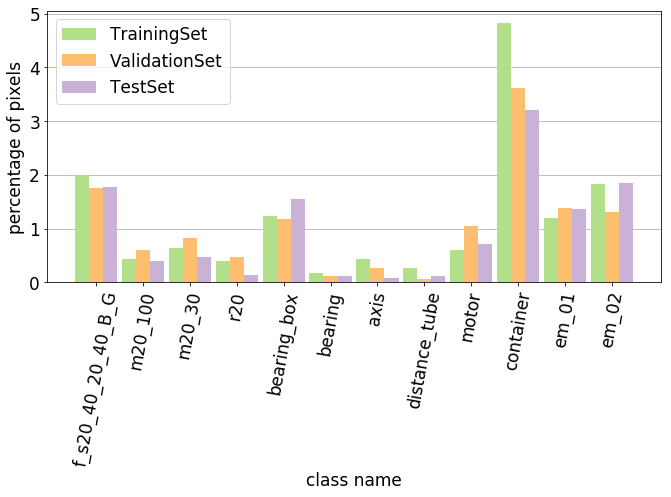

Class to count with background....



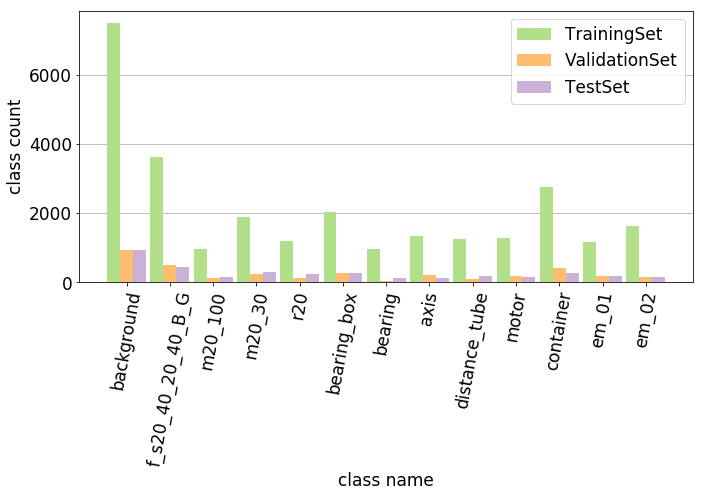

Class to count without background....



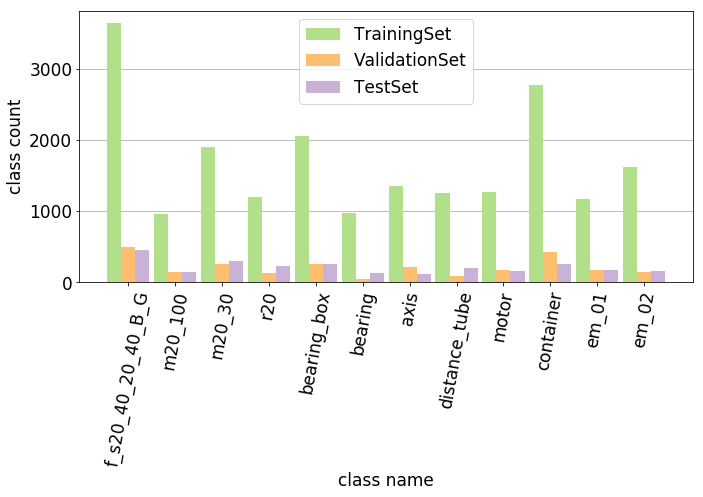

In [18]:
generate_results(analyzer_tr_shape_w, 
                 analyzer_va_shape_w, 
                 analyzer_te_shape_w, fig_width=11)

### Analysis of the atWork_binary variant of the shades of white dataset:

In [19]:
analyzer_tr_binary_w = DataAnalysis(VARIANT='white_binary', 
                        LABEL_PATH='./objects/white_real_augmented/training/binary')
analyzer_va_binary_w = DataAnalysis(VARIANT='white_binary', 
                        LABEL_PATH='./objects/white_real_augmented/validation/binary')
analyzer_te_binary_w = DataAnalysis(VARIANT='white_binary', 
                        LABEL_PATH='./objects/white_real_augmented/test/binary')

Percentage of pixels of each class in the training set:

{'background': 85.9785, 'foreground': 14.0215}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 87.3322, 'foreground': 12.6678}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 88.2367, 'foreground': 11.7633}
-----------------------------------------------------------

Class to percentage with background....



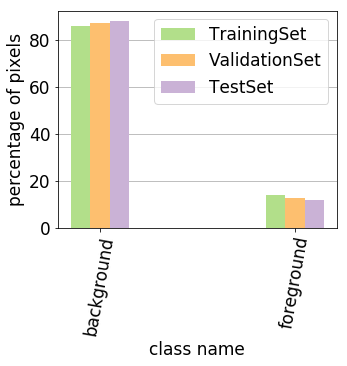

Class to percentage without background....



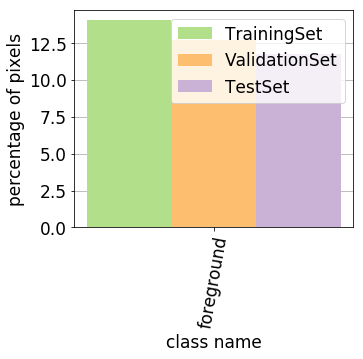

Class to count with background....



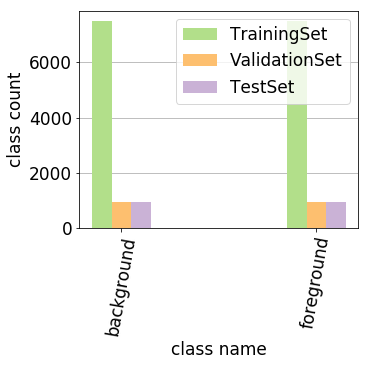

Class to count without background....



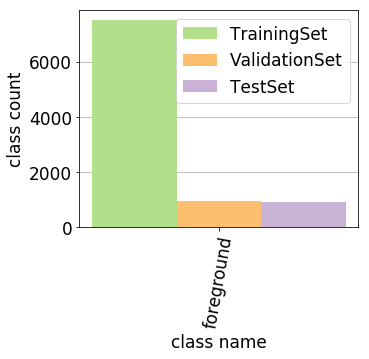

In [20]:
generate_results(analyzer_tr_binary_w, 
                 analyzer_va_binary_w, 
                 analyzer_te_binary_w, fig_width=5, fig_height=4, bar_width=0.1)

### Analysis of full labels of real data:

In [21]:
analyzer_tr_full_real = DataAnalysis(VARIANT='real_full', 
                        LABEL_PATH='./objects/real_or_aug_train/training_real/full')
analyzer_va_full_real = DataAnalysis(VARIANT='real_full', 
                        LABEL_PATH='./objects/real_or_aug_train/validation_real/full')
analyzer_te_full_real = DataAnalysis(VARIANT='real_full', 
                        LABEL_PATH='./objects/real_or_aug_train/test_real/full')

Percentage of pixels of each class in the training set:

{'background': 95.0095, 'f20_20_B': 0.1273, 's40_40_B': 0.1786, 'f20_20_G': 0.1415, 's40_40_G': 0.316, 'm20_100': 0.1897, 'm20': 0.1101, 'm30': 0.1465, 'r20': 0.1427, 'bearing_box_ax01': 0.2888, 'bearing': 0.1025, 'axis': 0.1408, 'distance_tube': 0.0334, 'motor': 0.2457, 'container_box_blue': 0.8168, 'container_box_red': 0.8015, 'bearing_box_ax16': 0.1995, 'em_01': 0.4622, 'em_02': 0.5469}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 96.004, 'f20_20_B': 0.121, 's40_40_B': 0.0765, 'f20_20_G': 0.1315, 's40_40_G': 0.3136, 'm20_100': 0.1959, 'm20': 0.1382, 'm30': 0.1628, 'r20': 0.1604, 'bearing_box_ax01': 0.2256, 'bearing': 0.089, 'axis': 0.0736, 'distance_tube': 0.0238, 'motor': 0.2641, 'container_box_blue': 0.555, 'container_box_red': 0.3602, 'bearing_box_ax16': 0.1421, 'em_01': 0.4058, 'em_02': 0.557}
-----------------------------------------

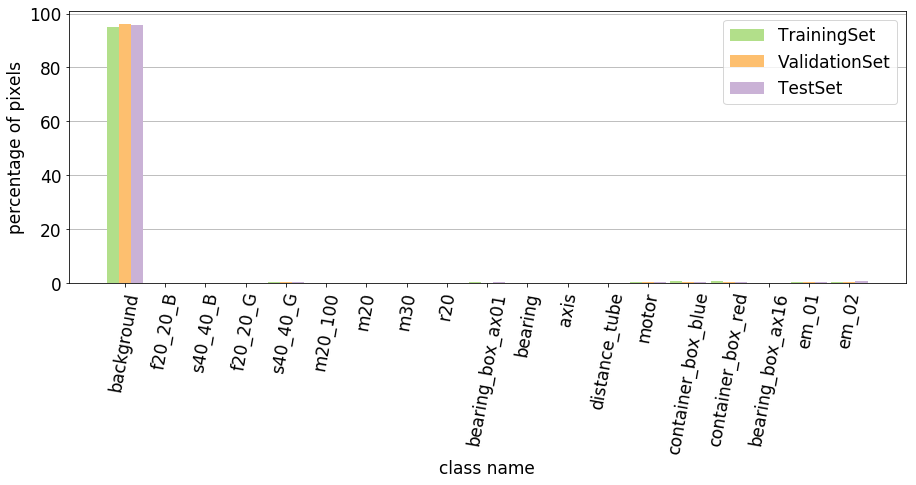

Class to percentage without background....



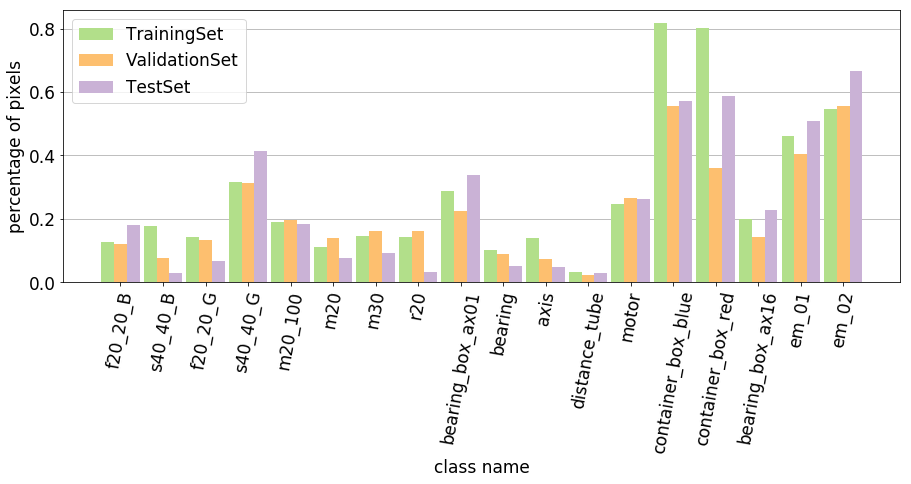

Class to count with background....



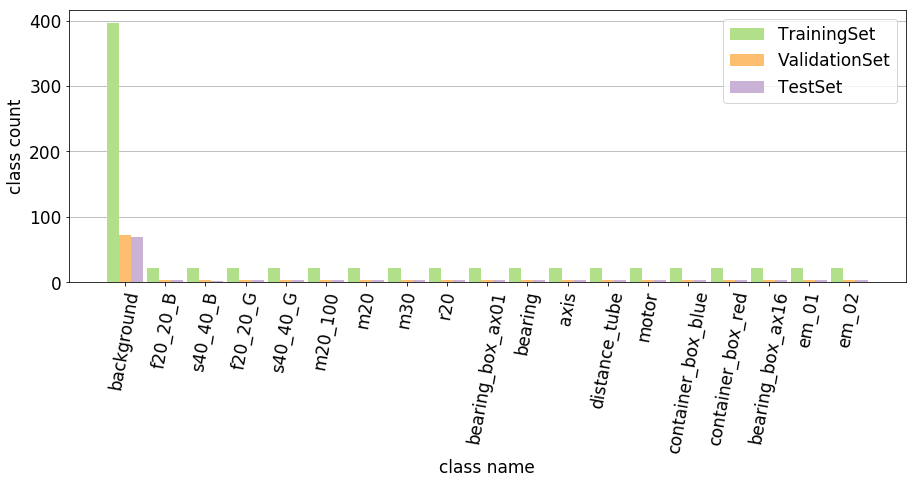

Class to count without background....



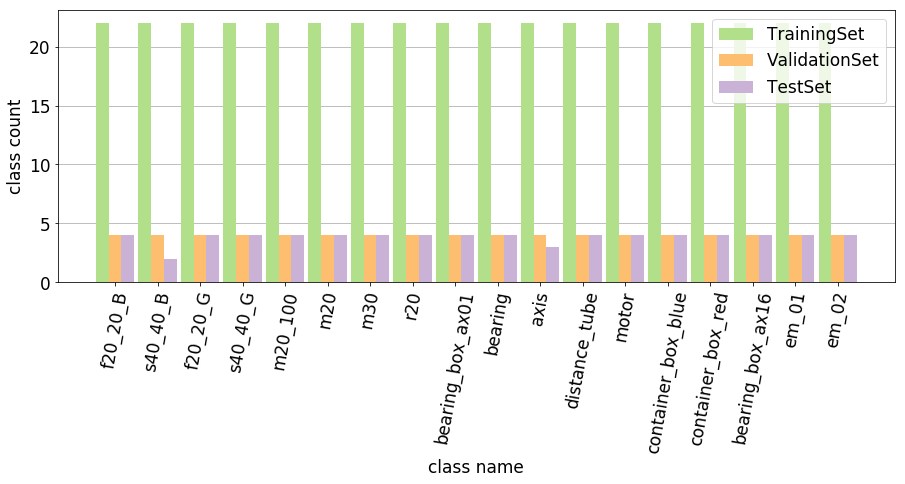

In [22]:
generate_results(analyzer_tr_full_real, 
                 analyzer_va_full_real, 
                 analyzer_te_full_real)

### Analysis of size invariant labels of real data:

In [23]:
analyzer_tr_size_real = DataAnalysis(VARIANT='real_size', 
                        LABEL_PATH='./objects/real_or_aug_train/training_real/size_invariant')
analyzer_va_size_real = DataAnalysis(VARIANT='real_size', 
                        LABEL_PATH='./objects/real_or_aug_train/validation_real/size_invariant')
analyzer_te_size_real = DataAnalysis(VARIANT='real_size', 
                        LABEL_PATH='./objects/real_or_aug_train/test_real/size_invariant')

Percentage of pixels of each class in the training set:

{'background': 95.0095, 'f_s20_40_20_40_B': 0.3059, 'f_s20_40_20_40_G': 0.4575, 'm20_100': 0.1897, 'm20_30': 0.2565, 'r20': 0.1427, 'bearing_box': 0.4883, 'bearing': 0.1025, 'axis': 0.1408, 'distance_tube': 0.0334, 'motor': 0.2457, 'container_box_blue': 0.8168, 'container_box_red': 0.8015, 'em_01': 0.4622, 'em_02': 0.5469}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 96.004, 'f_s20_40_20_40_B': 0.1975, 'f_s20_40_20_40_G': 0.4451, 'm20_100': 0.1959, 'm20_30': 0.301, 'r20': 0.1604, 'bearing_box': 0.3677, 'bearing': 0.089, 'axis': 0.0736, 'distance_tube': 0.0238, 'motor': 0.2641, 'container_box_blue': 0.555, 'container_box_red': 0.3602, 'em_01': 0.4058, 'em_02': 0.557}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 95.6359, 'f_s20_40_20_40_B': 0.2072, 'f_s20_40_20

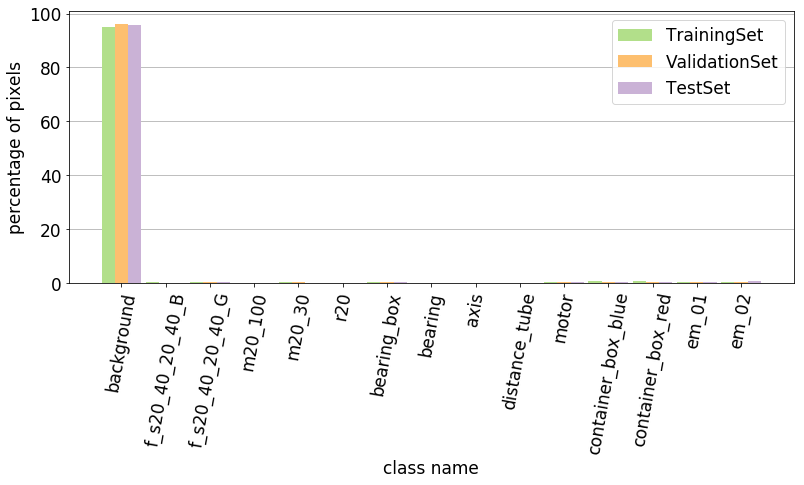

Class to percentage without background....



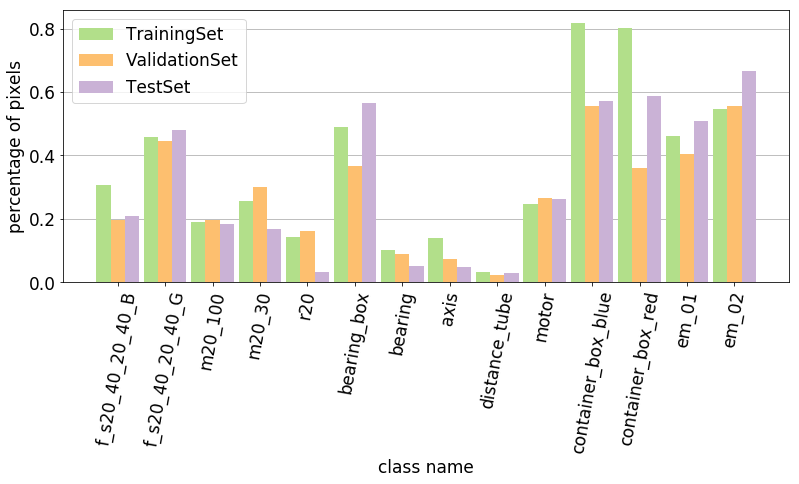

Class to count with background....



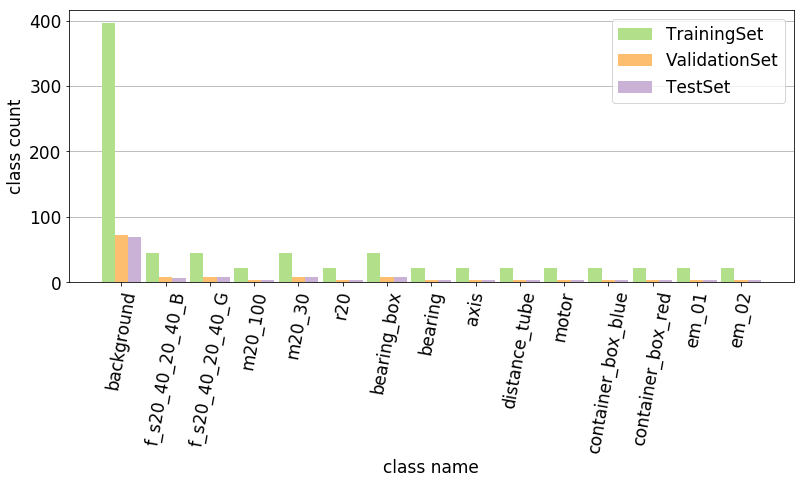

Class to count without background....



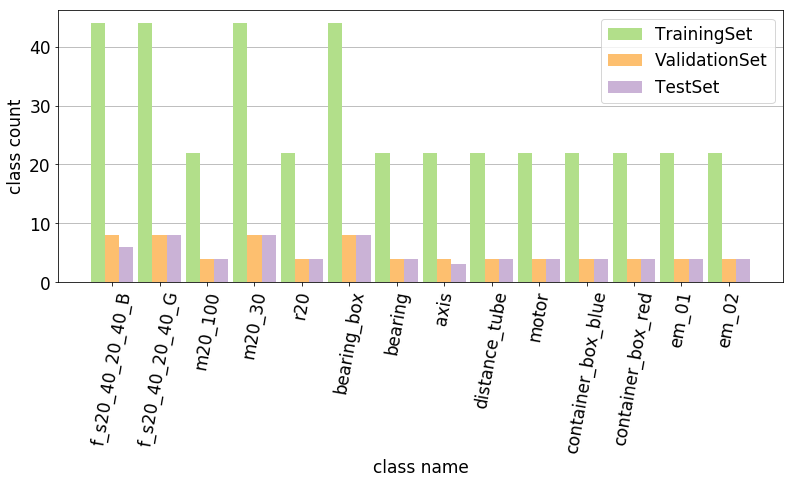

In [24]:
generate_results(analyzer_tr_size_real, 
                 analyzer_va_size_real, 
                 analyzer_te_size_real, fig_width=13)

### Analysis of similar shapes labels of real data:

In [25]:
analyzer_tr_shape_real = DataAnalysis(VARIANT='real_shape', 
                        LABEL_PATH='./objects/real_or_aug_train/training_real/similar_shapes')
analyzer_va_shape_real = DataAnalysis(VARIANT='real_shape', 
                        LABEL_PATH='./objects/real_or_aug_train/validation_real/similar_shapes')
analyzer_te_shape_real = DataAnalysis(VARIANT='real_shape', 
                        LABEL_PATH='./objects/real_or_aug_train/test_real/similar_shapes')

Percentage of pixels of each class in the training set:

{'background': 95.0095, 'f_s20_40_20_40_B_G': 0.7634, 'm20_100': 0.1897, 'm20_30': 0.2565, 'r20': 0.1427, 'bearing_box': 0.4883, 'bearing': 0.1025, 'axis': 0.1408, 'distance_tube': 0.0334, 'motor': 0.2457, 'container': 1.6183, 'em_01': 0.4622, 'em_02': 0.5469}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 96.004, 'f_s20_40_20_40_B_G': 0.6426, 'm20_100': 0.1959, 'm20_30': 0.301, 'r20': 0.1604, 'bearing_box': 0.3677, 'bearing': 0.089, 'axis': 0.0736, 'distance_tube': 0.0238, 'motor': 0.2641, 'container': 0.9152, 'em_01': 0.4058, 'em_02': 0.557}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 95.6359, 'f_s20_40_20_40_B_G': 0.6883, 'm20_100': 0.1843, 'm20_30': 0.1688, 'r20': 0.0306, 'bearing_box': 0.5662, 'bearing': 0.0495, 'axis': 0.0485, 'distance_tube': 0.0285, 'm

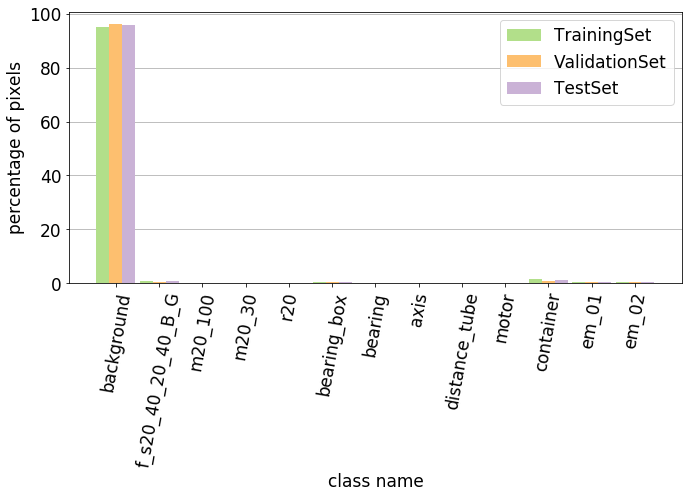

Class to percentage without background....



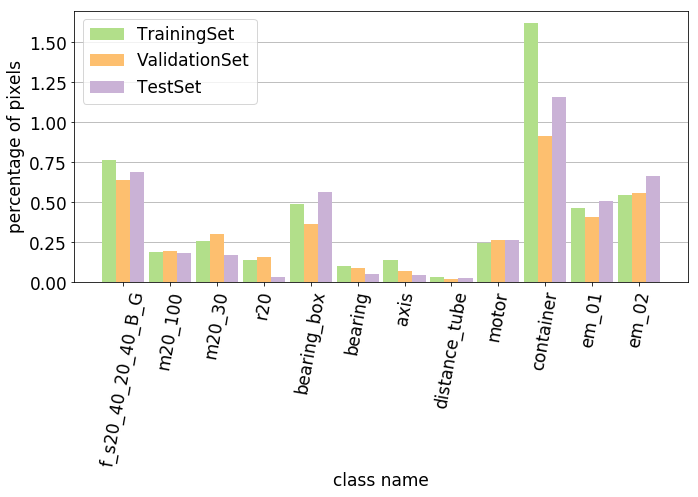

Class to count with background....



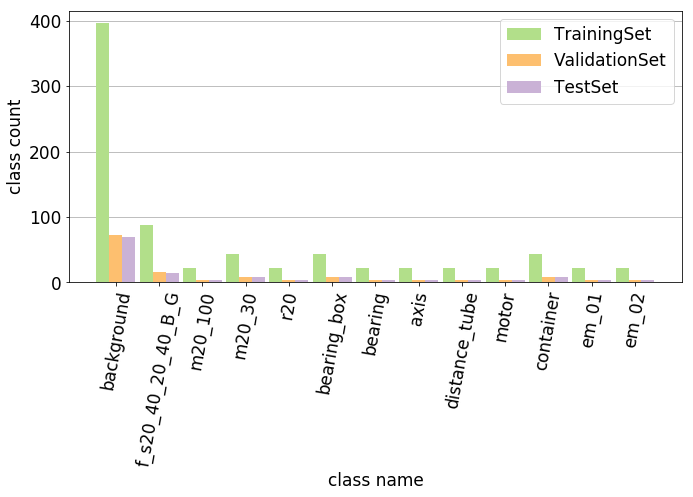

Class to count without background....



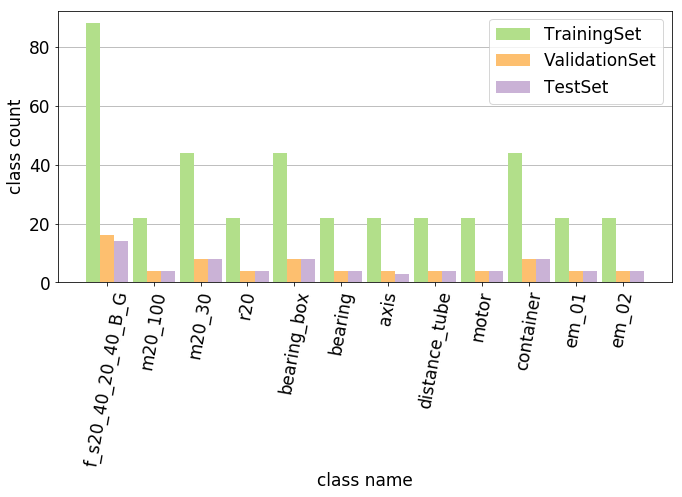

In [26]:
generate_results(analyzer_tr_shape_real, 
                 analyzer_va_shape_real, 
                 analyzer_te_shape_real, fig_width=11)

### Analysis of binary labels of real data:

In [27]:
analyzer_tr_binary_real = DataAnalysis(VARIANT='real_binary', 
                        LABEL_PATH='./objects/real_or_aug_train/training_real/binary')
analyzer_va_binary_real = DataAnalysis(VARIANT='real_binary', 
                        LABEL_PATH='./objects/real_or_aug_train/validation_real/binary')
analyzer_te_binary_real = DataAnalysis(VARIANT='real_binary', 
                        LABEL_PATH='./objects/real_or_aug_train/test_real/binary')

Percentage of pixels of each class in the training set:

{'background': 95.0095, 'foreground': 4.9905}
-----------------------------------------------------------

Percentage of pixels of each class in the validation set:

{'background': 96.004, 'foreground': 3.996}
-----------------------------------------------------------

Percentage of pixels of each class in the test set:

{'background': 95.6359, 'foreground': 4.3641}
-----------------------------------------------------------

Class to percentage with background....



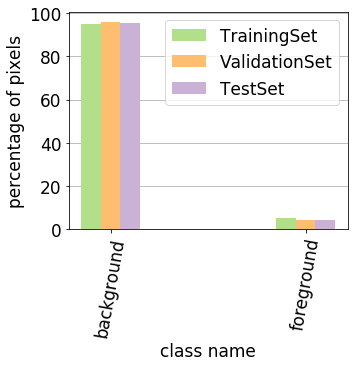

Class to percentage without background....



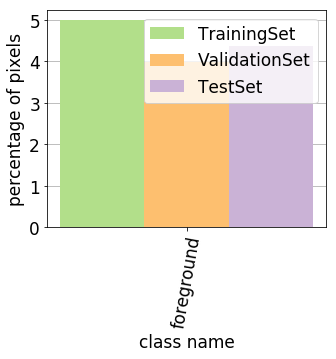

Class to count with background....



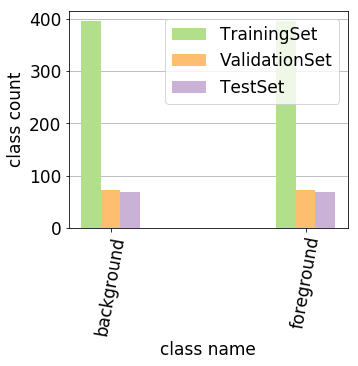

Class to count without background....



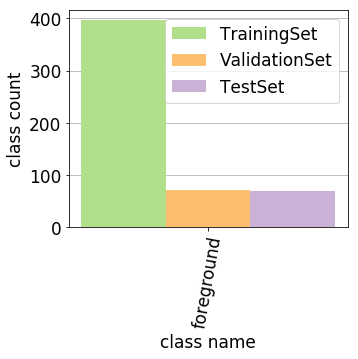

In [28]:
generate_results(analyzer_tr_binary_real, 
                 analyzer_va_binary_real, 
                 analyzer_te_binary_real, fig_width=5, fig_height=4, bar_width=0.1)